# 2025-02-24 Differentiation, Blasius activity

## Last time

* p-Laplacian
* Automatic differentiaton

## Today

* Boundary conditions in the residual
* NLsolve Newton solver library
  * p-Laplacian robustness
  * diagnostics
* Algorithmic differentiation via Zygote
* Blasius

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end


function advdiff_sparse(n, kappa, wind, forcing)
    x = LinRange(-1, 1, n)
    xstag = (x[1:end-1] + x[2:end]) / 2
    rhs = forcing.(x)
    kappa_stag = kappa.(xstag)
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    rhs[[1,n]] .= 0 # boundary condition
    for i in 2:n-1
        flux_L = -kappa_stag[i-1] * fdstencil(x[i-1:i], xstag[i-1], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        flux_R = -kappa_stag[i] * fdstencil(x[i:i+1], xstag[i], 1) +
            wind * (wind > 0 ? [1 0] : [0 1])
        weights = fdstencil(xstag[i-1:i], x[i], 1)
        append!(rows, [i,i,i])
        append!(cols, i-1:i+1)
        append!(vals, weights[1] *  [flux_L..., 0] + weights[2] * [0, flux_R...])
    end
    L = sparse(rows, cols, vals)
    x, L, rhs
end

function newton(residual, jacobian, u0; maxits=20)
    u = u0
    uhist = [copy(u)]
    normhist = []
    for k in 1:maxits
        f = residual(u)
        push!(normhist, norm(f))
        J = jacobian(u)
        delta_u = - J \ f
        u += delta_u
        push!(uhist, copy(u))
    end
    uhist, normhist
end

newton (generic function with 1 method)

# $p$-Laplacian

$$ -\big(|u_x|^{p-2} u_x\big)_x = b(x) \quad \text{ in } \Omega = (-1, 1), \quad u(-1) = 0, \quad u(1) = 1 $$

In [37]:
plaplace_p = 1.5
plaplace_forcing = 0. # b(x) above
function plaplace_f(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        u_xstag = diff(u[i-1:i+1]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        f[i] = [1/h, -1/h]' *
            (kappa_stag .* u_xstag) - plaplace_forcing
    end
    f
end

plaplace_f (generic function with 1 method)

**Questions**: 
- Lines 10-14 encode a measure of how well the PDE is satisfied, the residual. Can you find a formula for it?
- Which part of the residual do lines 7-9 encode? _Hint_: how does our method make sure that the boundary conditions are satisfied?

In [38]:
function plaplace_J(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        u_xstag = diff(u[js]) / h
        kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
        fi = [h, -h]' * (kappa_stag .* u_xstag)
        fi_ujs = [-kappa_stag[1]/h^2,
                  sum(kappa_stag)/h^2,
                  -kappa_stag[2]/h^2]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_J (generic function with 1 method)

# Try solving

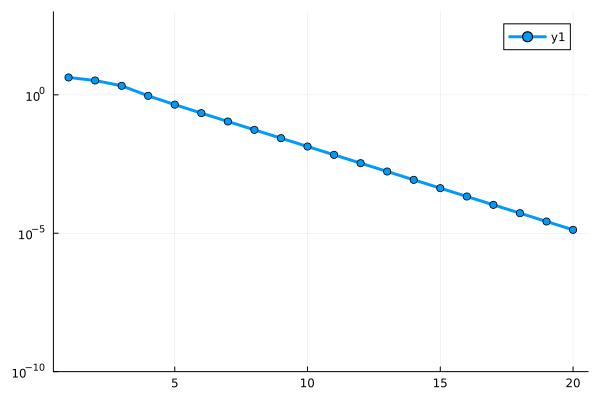

In [39]:
n = 20
x = collect(LinRange(-1., 1, n))
u0 = (1 .+ x) / 2

plaplace_p = 1.5 # try different values
plaplace_forcing = 1
uhist, normhist = newton(plaplace_f, plaplace_J, u0; maxits=20);
plot(normhist, marker=:circle, yscale=:log10, ylims=(1e-10, 1e3))

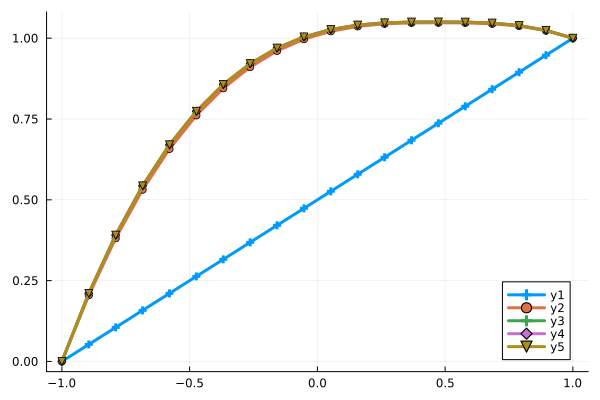

In [40]:
plot(x, uhist[1:5:end], marker=:auto, legend=:bottomright)

## What's wrong?

# Using Zygote to differentiate

In [6]:
using Zygote

gradient(x -> x^2, 3)

(6.0,)

In [7]:
function plaplace_fpoint(u, h)
    u_xstag = diff(u) / h
    kappa_stag = abs.(u_xstag) .^ (plaplace_p - 2)
    [1/h, -1/h]' * (kappa_stag .* u_xstag)
end

gradient(u -> plaplace_fpoint(u, .1), [0., .7, 1.])

([-18.898223650461365, 47.76573710994265, -28.867513459481284],)

# p-Laplacian with Zygote

In [41]:
function plaplace_fzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    f = copy(u)
    u[[1, n]] = [0, 1]
    f[n] -= 1
    for i in 2:n-1
        f[i] = plaplace_fpoint(u[i-1:i+1], h) - plaplace_forcing
    end
    f
end

plaplace_fzygote (generic function with 1 method)

In [42]:
function plaplace_Jzygote(u)
    n = length(u)
    h = 2 / (n - 1)
    u = copy(u)
    u[[1, n]] = [0, 1]
    rows = [1, n]
    cols = [1, n]
    vals = [1., 1.] # diagonals entries (float)
    for i in 2:n-1
        js = i-1:i+1
        fi_ujs = gradient(ujs -> plaplace_fpoint(ujs, h), u[js])[1]
        mask = 1 .< js .< n
        append!(rows, [i,i,i][mask])
        append!(cols, js[mask])
        append!(vals, fi_ujs[mask])
    end
    sparse(rows, cols, vals)
end

plaplace_Jzygote (generic function with 1 method)

# Experiment with parameters

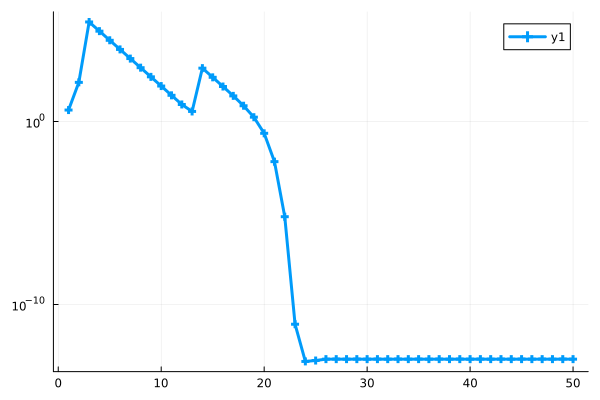

In [44]:
plaplace_p = 5
plaplace_forcing = 1
u0 = (x .+ 1) / 2 # Question: Why this starting solution?
uhist, normhist = newton(plaplace_fzygote, plaplace_Jzygote, u0; maxits=50);
plot(normhist, marker=:auto, yscale=:log10)

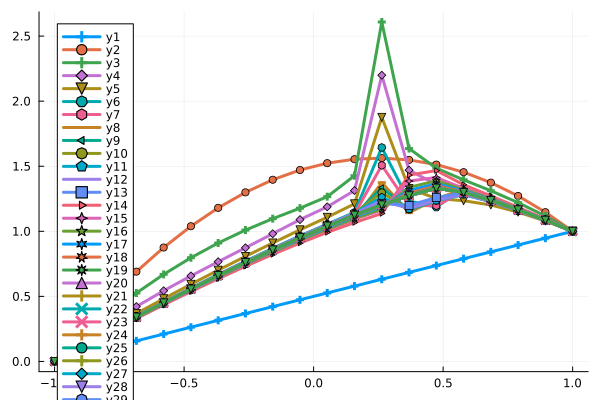

In [45]:
plot(x, uhist, marker=:auto, legend=:topleft)

* What is causing Newton to diverge?
* How might we fix or work around it?

# A model problem for Newton divergence; compare NLsolve

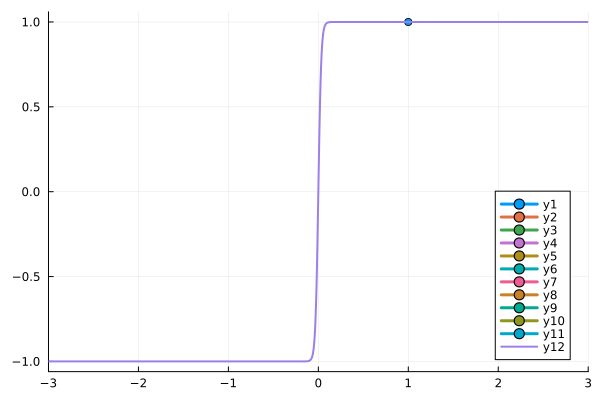

In [50]:
k = 31.0 # what happens as this is changed
fk(x) = tanh.(k*x)
Jk(x) = reshape(k / cosh.(k*x).^2, 1, 1)
xhist, normhist = newton(fk, Jk, [1.], maxits=10)
plot(xhist, fk.(xhist), marker=:circle, legend=:bottomright)
plot!(fk, xlims=(-3, 3), linewidth=2)

In [51]:
# using Pkg; Pkg.add("NLsolve")
using NLsolve

nlsolve(x -> fk(x), Jk, [4.], show_trace=true)

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     1.000000e+00              NaN
     1     0.000000e+00     4.000000e+00


Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [4.0]
 * Zero: [0.0]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 2

## How does `NLsolve` work?

- Why did we switch to Newton's method in the first place?
    - To accelerate convergence
    - This came at the price of needing to supply the derivative/Jacobian
- But, bisection more robust: best algorithms combine them
    - Bisection for robustness, use derivative for acceleration
    - e.g. [falsi method](https://en.wikipedia.org/wiki/Regula_falsi#The_regula_falsi_(false_position)_method)

# [NLsolve](https://juliapackages.com/p/nlsolve) for p-Laplacian

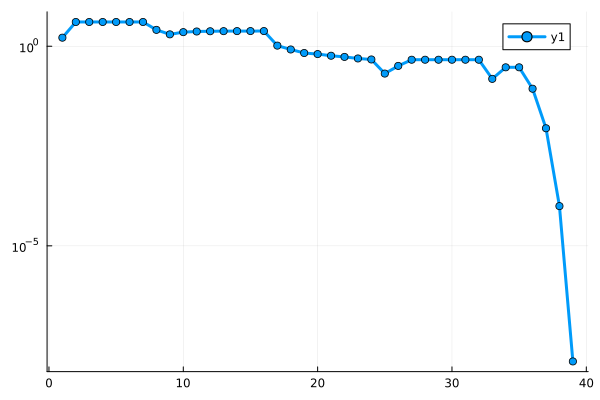

In [55]:
plaplace_p = 1.45
plaplace_forcing = 1
u0 = (x .+ 1) / 2
sol = nlsolve(plaplace_fzygote, plaplace_Jzygote, u0, 
    store_trace=true)
plaplace_p = 1.3
sol = nlsolve(plaplace_fzygote, plaplace_Jzygote, sol.zero, 
    store_trace=true)
fnorms = [sol.trace[i].fnorm for i in 1:sol.iterations]
plot(fnorms, marker=:circle, yscale=:log10)

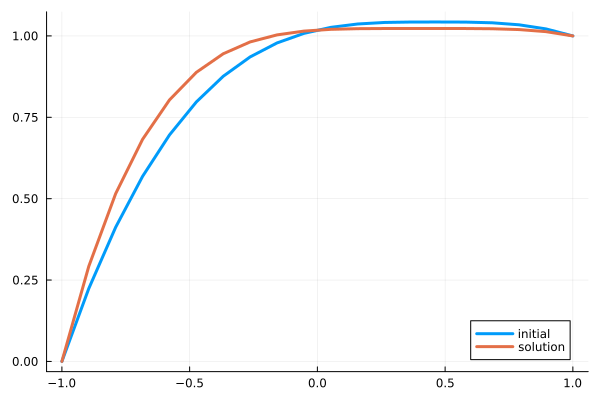

In [56]:
plot(x, [sol.initial_x sol.zero], label=["initial" "solution"])

# [Compressible Blasius boundary layer](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Compressible_Blasius_boundary_layer)

* Activity will solve this 1D nonlinear PDE